## Part-A

DOMAIN: Entertainment
- CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the
- DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.
- PROJECT OBJECTIVE: To build a face detection system.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from multiprocessing import Pool

In [5]:

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

In [3]:
cd "/content/drive/MyDrive/OpenCV"

/content/drive/MyDrive/OpenCV


In [ ]:
os.listdir()

['images.npy',
 'vgg_face_weights.h5',
 'PINS.zip',
 'testImage1.jpeg',
 'testImage2.jpeg',
 'training_images.zip',
 '.ipynb_checkpoints',
 'training_images',
 'haarcascade_frontalface_default.xml',
 'face_data.csv',
 'PINS']

In [ ]:
data = np.load('images.npy', allow_pickle=True)

In [ ]:
data.shape

(409, 2)

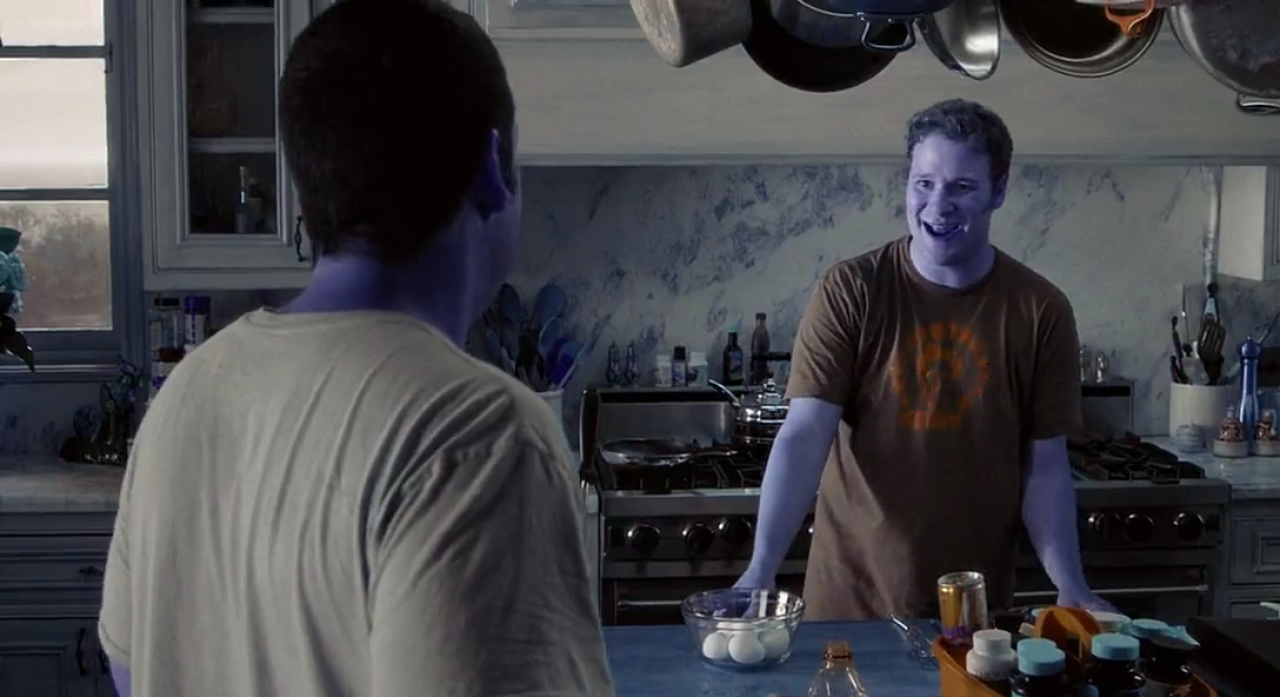

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[1][0])

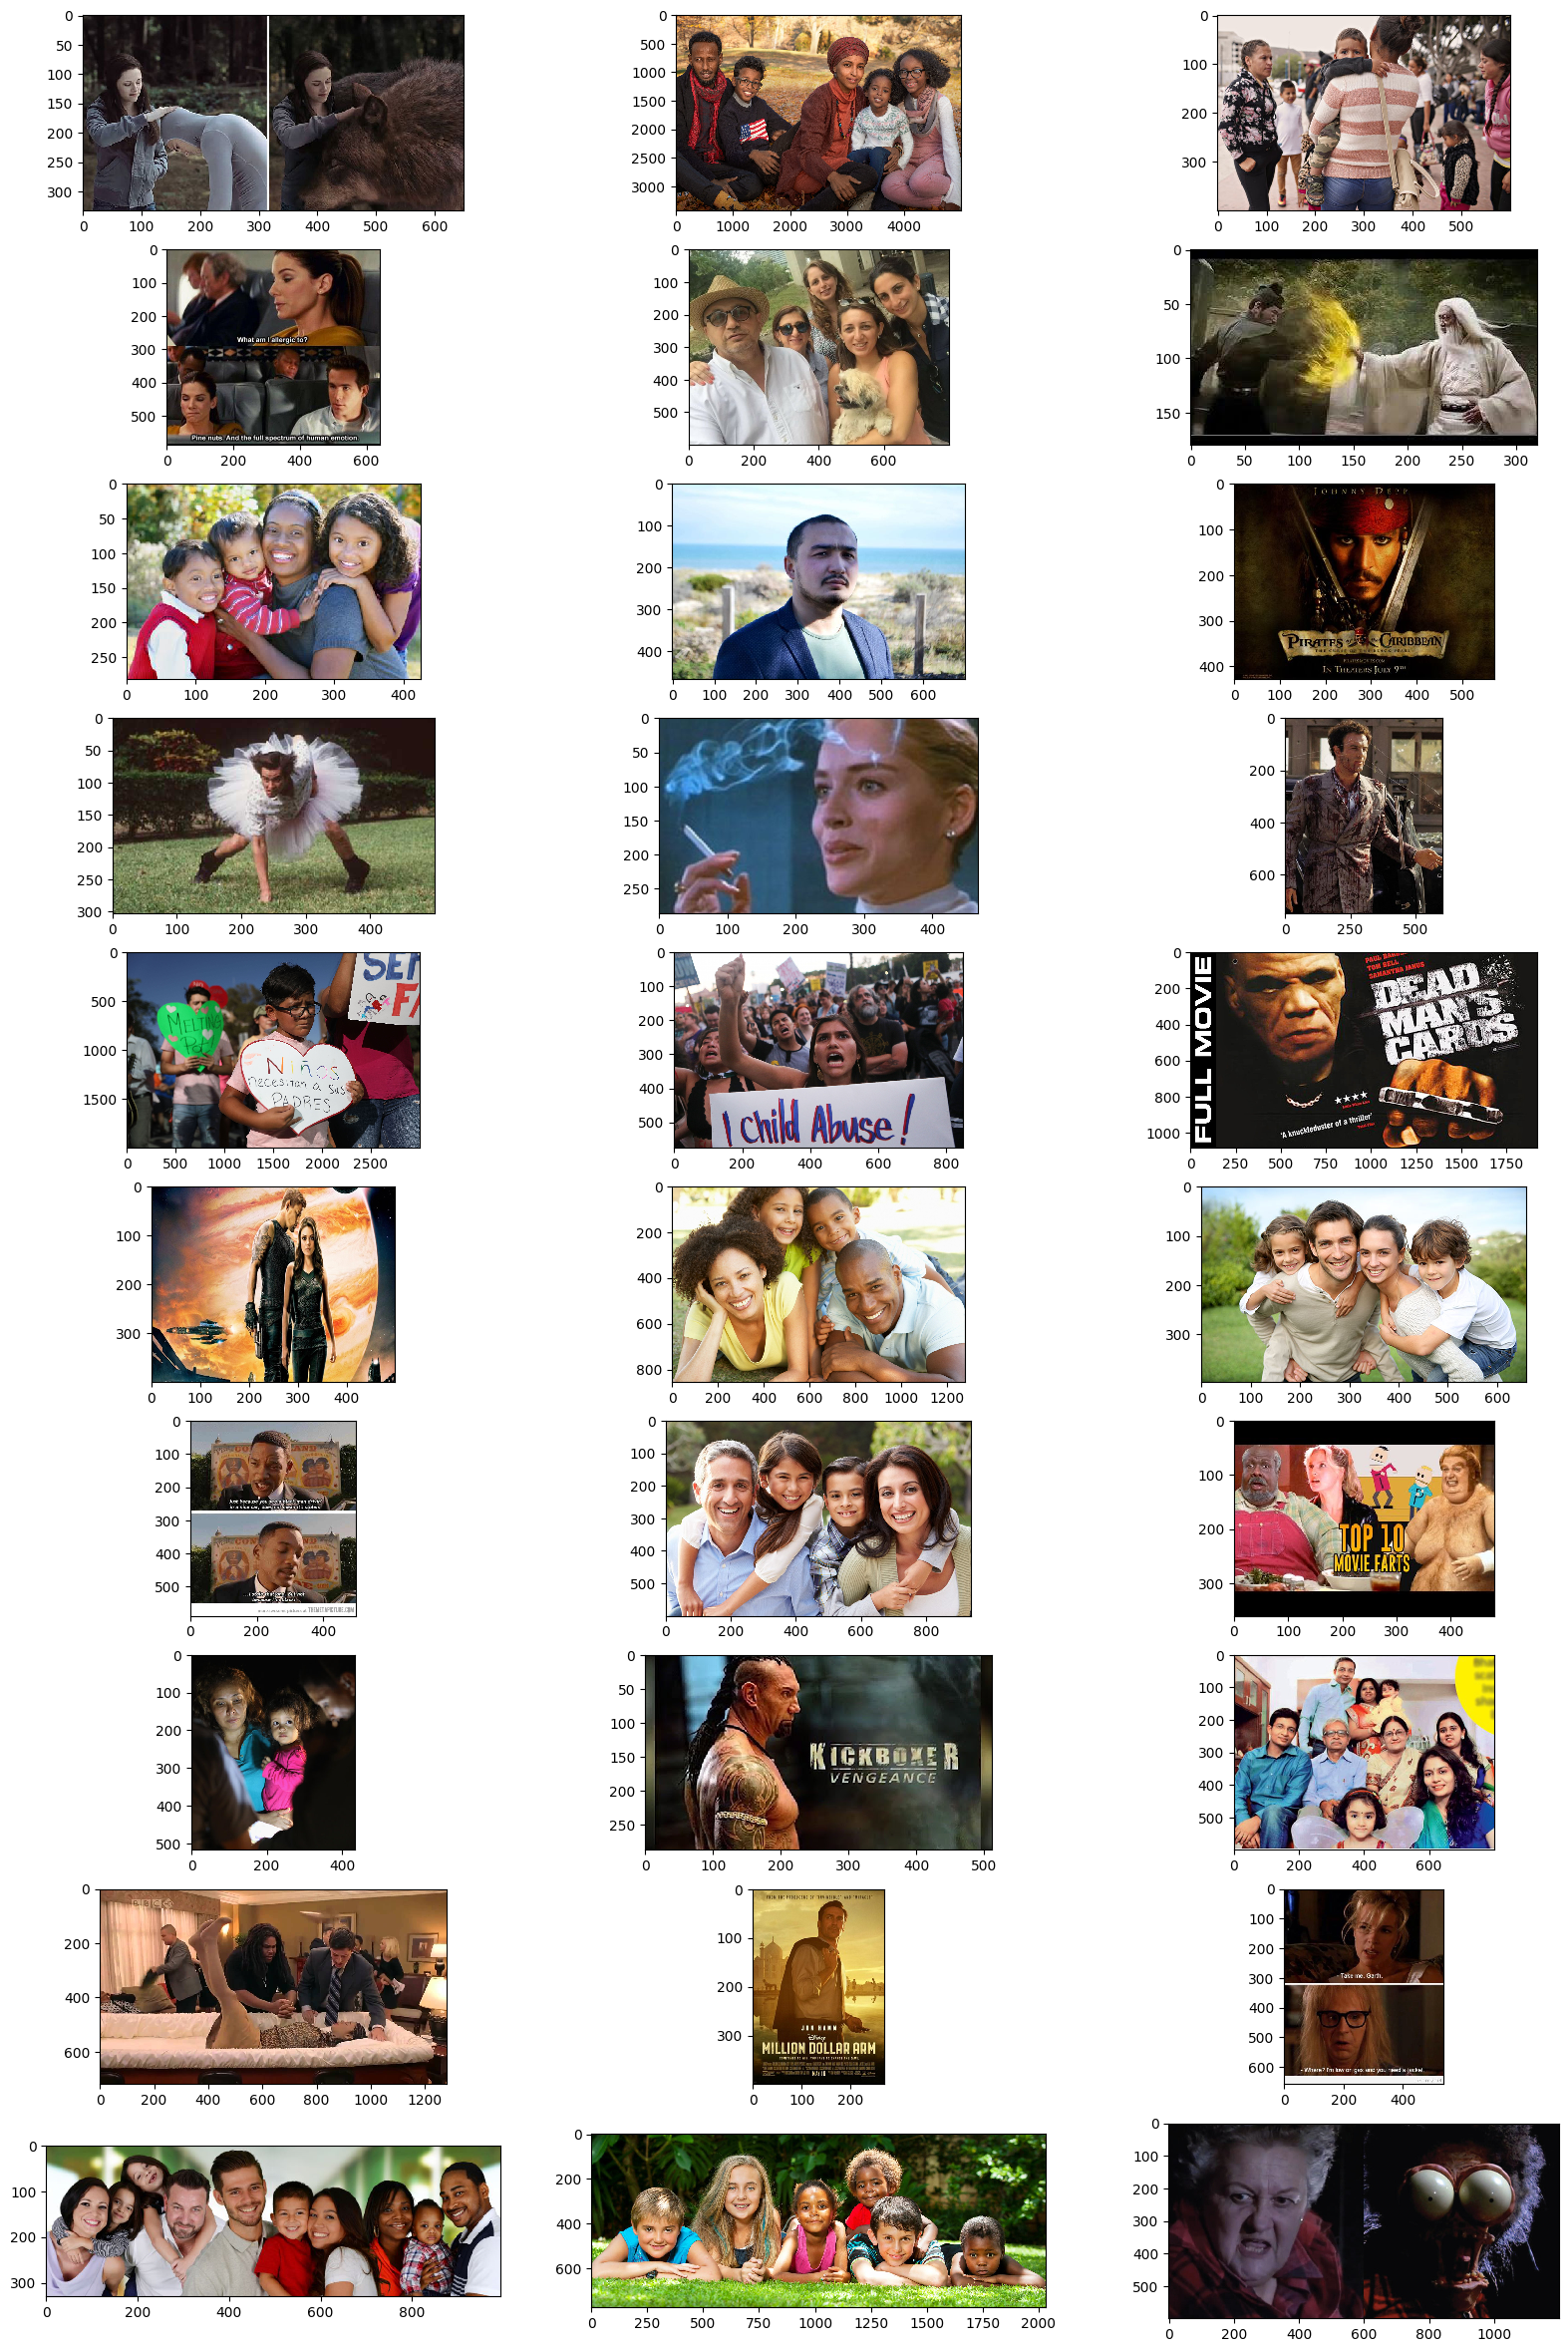

In [ ]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

Creating features (images) and labels (mask)

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input


masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  """ assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel.
  The alpha channel is a special channel that handles transparency. When an image has an alpha channel on it,
  it means you can adjust the image's opacity levels and make bits translucent or totally see-through.
  The alpha channel is instrumental when you want to remove the background from an image."""
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


Split the data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Checking the image (features) and mask

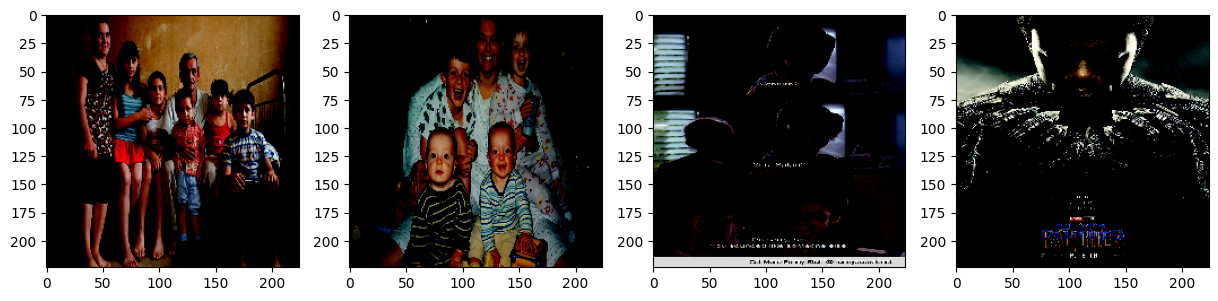

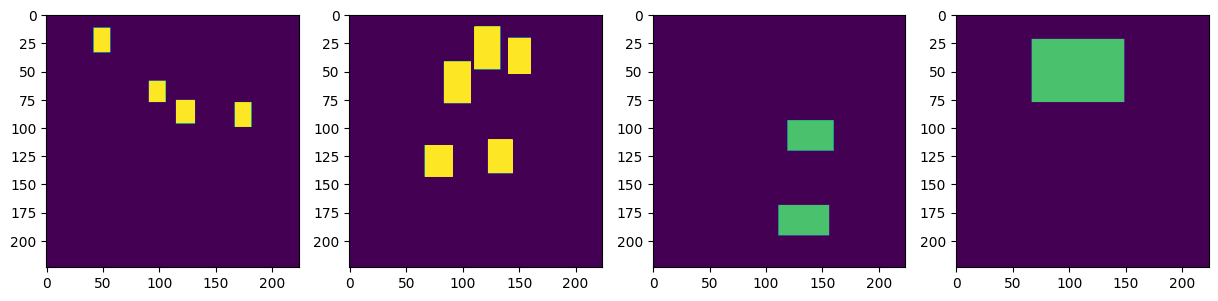

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

Mask Detection Model

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 10
BATCH = 8
LR = 1e-4

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

2019640/2019640 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10
41/41 [==============================] - 219s 4s/step - loss: 0.7370 - dice_coef: 0.2631 - recall: 0.7792 - precision: 0.1835 - val_loss: 0.8001 - val_dice_coef: 0.2052 - val_recall: 0.9999 - val_precision: 0.1020 - lr: 1.0000e-04
Epoch 2/10
41/41 [==============================] - 181s 4s/step - loss: 0.6295 - dice_coef: 0.3703 - recall: 0.9068 - precision: 0.3328 - val_loss: 0.7861 - val_dice_coef: 0.2195 - val_recall: 0.9988 - val_precision: 0.1165 - lr: 1.0000e-04
Epoch 3/10
41/41 [==============================] - 183s 4s/step - loss: 0.5720 - dice_coef: 0.4281 - recall: 0.9128 - precision: 0.4355 - val_loss: 0.7401 - val_dice_coef: 0.2662 - val_recall: 0.9877 - val_precision: 0.1708 - lr: 1.0000e-04
Epoch 4/10
41/41 [==============================] - 179s 4s/step - loss: 0.5419 - dice_coef: 0.4580 - recall: 0.9049 - precision: 0.4944 - val_loss: 0.7059 - val_dice_coef: 0.3010 - val_recall: 0.9727 - val_precision: 0.2316 - lr: 1.0000e-04
Epoch 5/10
41/41 [==============

In [ ]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 3s 1s/step - loss: 0.4868 - dice_coef: 0.5104 - recall: 0.8888 - precision: 0.5803


[0.4868078827857971,
 0.5103638768196106,
 0.8888236284255981,
 0.5803396105766296]

In [ ]:
filename = './testImage1.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

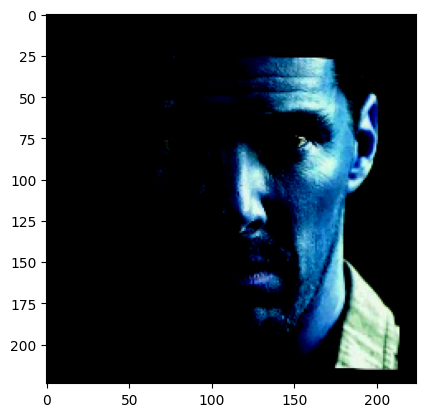

In [ ]:
plt.imshow(feat_scaled)

1/1 [==============================] - 1s 1s/step


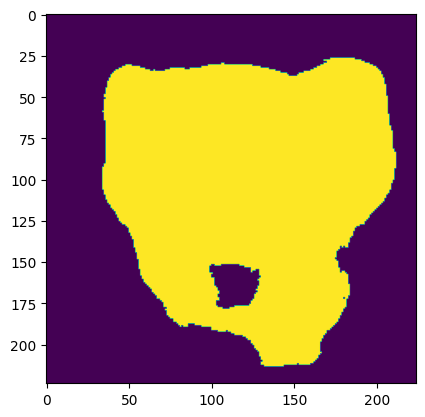

In [ ]:
y_pred = model.predict(np.array([feat_scaled]))
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(pred_mask)

In [ ]:
filename = './testImage2.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

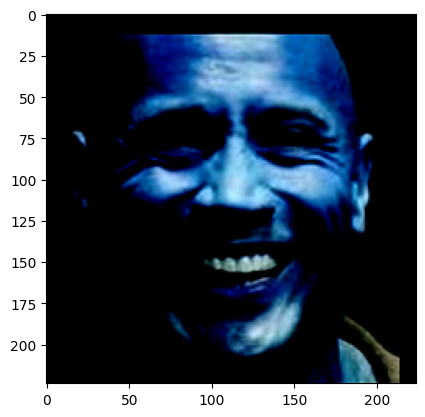

In [ ]:
plt.imshow(feat_scaled)

1/1 [==============================] - 0s 111ms/step


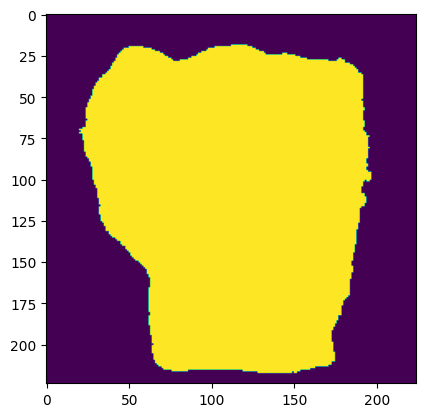

In [ ]:
y_pred = model.predict(np.array([feat_scaled]))
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(pred_mask)

The model is detecting the face mask pretty well

# Part B

DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the
• DATA DESCRIPTION: The dataset comprises of face images.
• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.
Steps and tasks: [ Total Score: 10 Marks]
1. Read/import images from folder ‘training_images’. [2 Marks]
2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]
Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.
3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]

In [ ]:
images_zip_path = './training_images.zip'
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [ ]:
import cv2
import os

# Path to the 'training_images' folder
folder_path = './training_images/'

# List all image files in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Initialize an empty list to store images
images = []

# Read and store images from the folder
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    images.append(image)

In [ ]:
# Initialize an empty list to store face metadata
face_metadata_list = []

# Load the face cascade classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Loop through all the images to detect faces and store metadata
for image_file in image_files:
    # Read the image
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)

    # Convert the image to grayscale (face detection works better in grayscale)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Append the metadata (x, y, width, height, image_name) of each face to the list
    for (x, y, w, h) in faces:
        face_metadata_list.append({
            'x': x,
            'y': y,
            'width': w,
            'height': h,
            'num_faces': len(faces),
            'image_name': image_file
        })

In [ ]:
import pandas as pd

# Create a DataFrame from the face metadata list
face_df = pd.DataFrame(face_metadata_list)

In [ ]:
face_df

x    y  width  height  num_faces      image_name
0    522  138     66      66          1  real_00947.jpg
1     45  136    396     396          1  real_01042.jpg
2     52  113    451     451          1  real_00964.jpg
3     68   50    471     471          1  real_01053.jpg
4    113  156    398     398          1  real_01057.jpg
..   ...  ...    ...     ...        ...             ...
944  120  179    374     374          1  real_00131.jpg
945   89  103    452     452          1  real_00394.jpg
946   82  131    397     397          1  real_00125.jpg
947   65   95    459     459          1  real_00134.jpg
948  120  169    363     363          1  real_00166.jpg

[949 rows x 6 columns]

In [ ]:
face_df.to_csv('face_data.csv')

# Part 3

DOMAIN: Face Recognition
• CONTEXT: Company X intends to build a face identification model to recognise human faces.
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

In [5]:
images_zip_path = './PINS.zip'
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [1]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('./PINS')

In [9]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [2]:
# Load an image
# for example, loading the image with index 1
load_image(metadata[0].image_path())

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [8]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [9]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [3]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

In [ ]:
embeddings = np.zeros((metadata.shape[0], embedding_vector.shape[0]))
for i, m in enumerate(metadata):
  try:
    img = load_image(m.image_path())
    # scale RGB values to interval [0,1]
    img = cv2.resize(img, dsize = (224,224))
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  except:
    pass

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
embeddings_array

array([], dtype=float64)

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7919799498746867

In [16]:
def predict_image(image):
    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (image / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    # Obtain embedding vector for an image
    # Get the embedding vector for the above image using vgg_face_descriptor model
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embedding_vector_normalized = sc.transform([embedding_vector])
    embedding_vector_normalized = pca.transform(embedding_vector_normalized)
    y_label = clf.predict(embedding_vector_normalized)
    # Convert y_pred_label back to the original label using encoder.inverse_transform
    label = encoder.inverse_transform(y_label)[0]
    return label

predicted label: pins_Benedict Cumberbatch


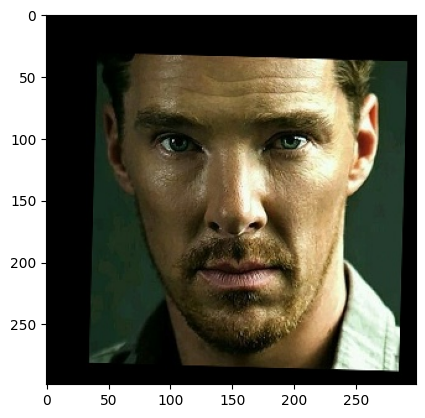

In [17]:
filename = './testImage1.jpeg'
testImage1 = load_image(filename)
plt.imshow(testImage1)
testImage1_label = predict_image(testImage1)
print("predicted label:", testImage1_label)

predicted label: pins_Dwayne johnson


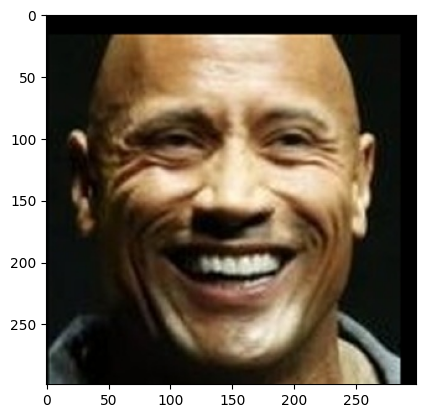

In [18]:
filename = './testImage2.jpeg'
testImage2 = load_image(filename)
plt.imshow(testImage2)
testImage2_label = predict_image(testImage2)
print("predicted label:", testImage2_label)